In [1]:
from pathlib import Path
import shutil
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from stable_baselines3 import PPO
from tqdm import tqdm

sys.path.append('../')
from env import *
from curriculum import *


"""Ensure all data files are located here"""
data_dir = Path('data/')


def load_runs(run_dir):
    run_dir = Path(run_dir)
    df = None
    for result_pkl in run_dir.iterdir():
        if type(df) == type(None):
            df = pd.read_pickle(result_pkl)
        else:
            tmp_df = pd.read_pickle(result_pkl)
            df = pd.concat((df ,tmp_df))

    def extract_plot_vals(row):
        traj_lens = [len(traj) for traj in row['runs']]
        assert len(traj_lens) == 1

        return pd.Series([
            row['name'],
            traj_lens[0]
        ], index=['name', 'traj_len'])

    plot_df = df.apply(extract_plot_vals, axis=1)
    return df, plot_df


def make_plot(df, plot_df, save_path=None):
    fig, axs = plt.subplots(1, 2, figsize=(8, 3))

    ax = sns.boxplot(plot_df, x='name', y='traj_len', ax=axs[0])
    ax.set_ylabel('Steps')
    ax.set_xlabel('')

    x_labs = ax.get_xticklabels()
    x_labs[0] = 'Adaptive'
    ax.set_xticklabels(x_labs)
    ax.set_title('Benchmarks')

    ### PLOT TRAJECTORIES
    for k, row in df.iterrows():
        if k == 2:
            break

        for i, traj in enumerate(row['runs']):
            if type(traj[0]) == tuple:
                traj = next(zip(*traj))  # remove extraneous output

            if i == 0:
                axs[1].plot(traj, label=row['name'], color=f'C{k}', alpha=0.5)
            else:
                axs[1].plot(traj, color=f'C{k}', alpha=0.6)

    axs[1].set_xlabel('Steps')
    axs[1].set_ylabel('Difficulty index')
    axs[1].legend(loc='lower right')
    axs[1].set_title('Trajectory')

    fig.tight_layout()

    if save_path is not None:
        plt.savefig(save_path)


def run_model(model_path, trail_map):
    model = PPO.load(model_path, device='cpu', custom_objects={'lr_schedule': 0, 'clip_range': 0})
    env = TrailEnv(trail_map, discrete=True, treadmill=True)

    obs = env.reset()
    all_obs = [obs]
    while True:
        action, _ = model.predict(obs, deterministic=True)
        obs, _, is_done, _ = env.step(action)

        all_obs.append(obs)

        if is_done:
            break

    return np.array(env.agent.position_history), {'agent': env.agent, 'obs': all_obs}


def plot_run(trail_map, pos_hist, save_path=None, ax=None, **plot_kwargs):
    if ax is None:
        ax = plt.gca()

    trail_map.plot(ax=ax, **plot_kwargs)
    ax.plot(pos_hist[:,0], pos_hist[:,1], linewidth=1.5, color='black')

    # fig.tight_layout()
    plt.axis('off')
    if save_path is not None:
        plt.savefig(save_path)


def plot_observations(i, obs, fig_path):
    obs_dir = fig_path / f'example_{i}_obs'
    if obs_dir.exists():
        shutil.rmtree(obs_dir)
    
    obs_dir.mkdir()
    for i, obs in enumerate(obs):
        plt.clf()
        plt.gca().set_axis_off()
        plt.imshow(obs / (np.max(obs, axis=(0, 1)) + 1e-8), interpolation='nearest')
        plt.savefig(obs_dir / f'obs_{i}.svg')


# Benchmark plots

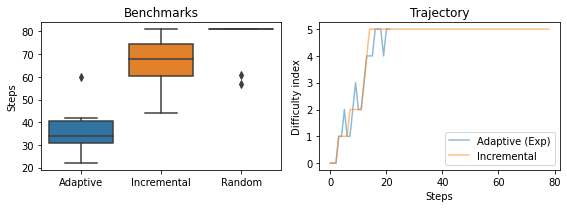

In [13]:
res = load_runs(data_dir / 'trail_runs')
make_plot(*res, 'fig/meander_bench.png')

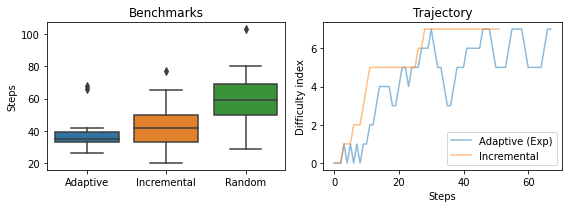

In [12]:
res = load_runs(data_dir / 'plume_runs')
make_plot(*res, 'fig/plume_bench.png')

# Plot sample runs

100%|██████████| 15/15 [05:42<00:00, 22.81s/it]


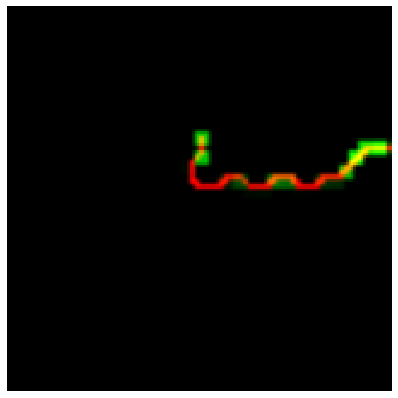

In [18]:
"""Meander trail"""

model_path = data_dir / 'meander_agent.zip'
save_path = Path('trail_examples/')
if not save_path.exists():
    save_path.mkdir()

if not save_path.exists():
    save_path.mkdir()

trail_args = {
    'width': 5,
    'diff_rate': 0.02,
    'radius': 70,
    'reward_dist': -1,
    'range': (-np.pi, np.pi)
}
trail_args['length'] = 500
trail_args['breaks'] = [(0.3, 0.32), (0.5, 0.53), (0.7, 0.72)]

"""Determine how many sample runs you would like"""
n_samps = 15

for i in tqdm(range(n_samps)):
    trail_map = MeanderTrail(**trail_args, heading=0)
    trail_map.max_steps = 1000

    pos_hist, info = run_model(model_path, trail_map)
    plt.clf()
    plot_run(trail_map, pos_hist, save_path=save_path / f'example_{i}.svg')
    plot_observations(i, info['obs'], save_path)

  0%|          | 0/15 [00:00<?, ?it/s]

100%|██████████| 15/15 [00:57<00:00,  3.82s/it]


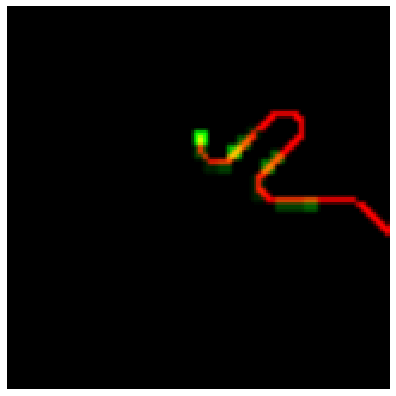

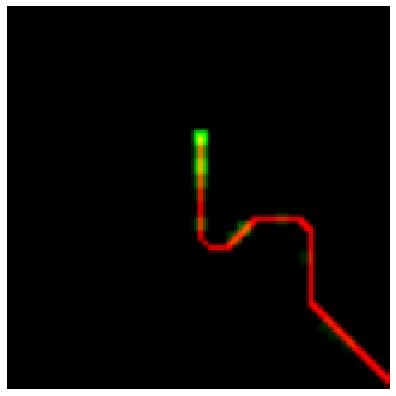

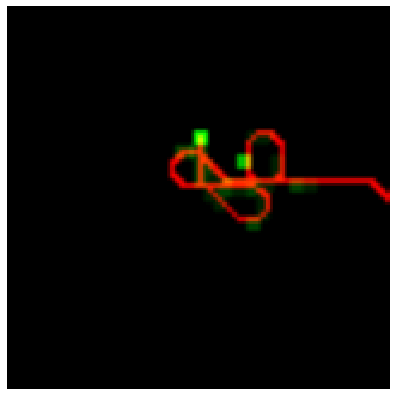

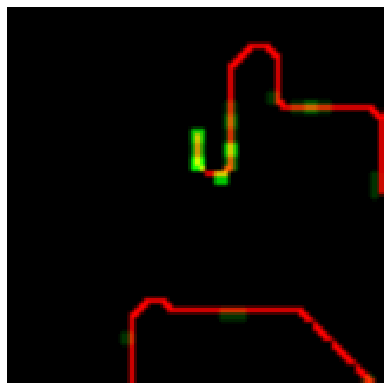

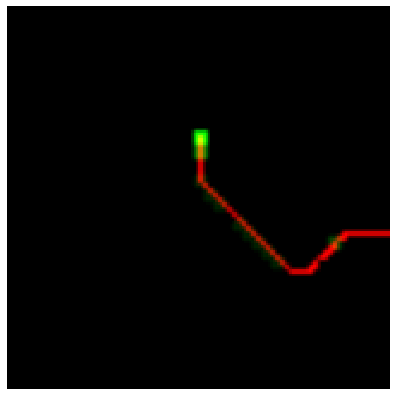

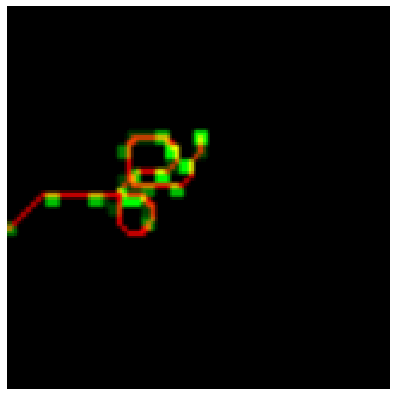

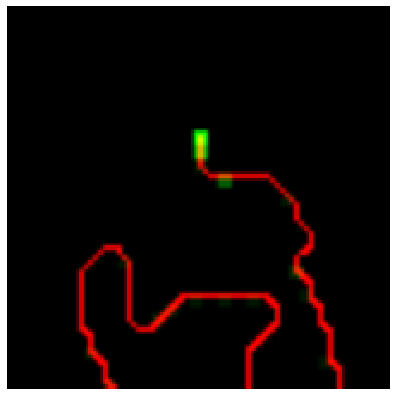

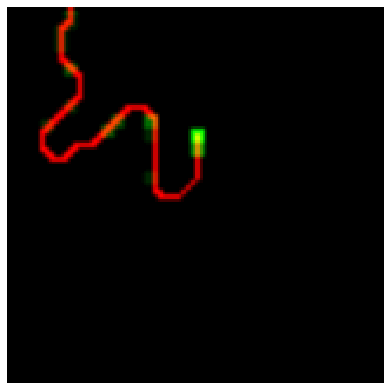

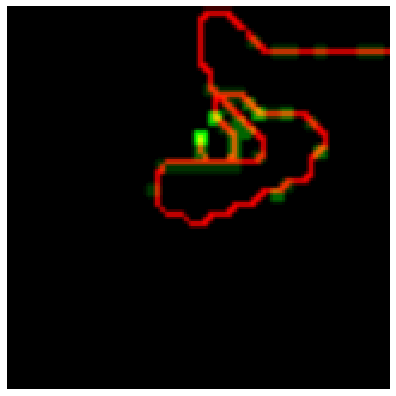

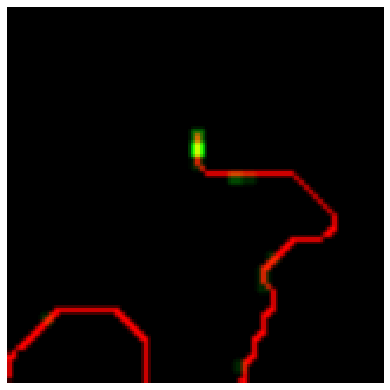

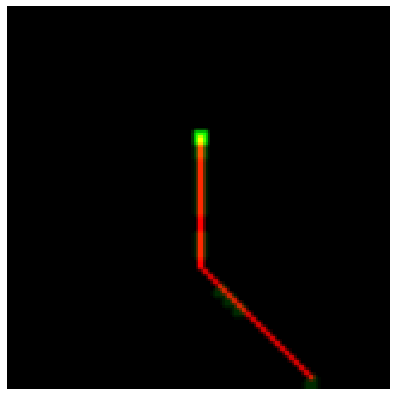

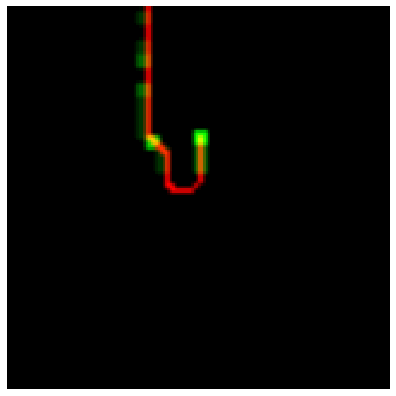

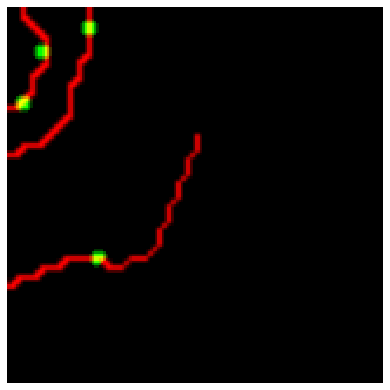

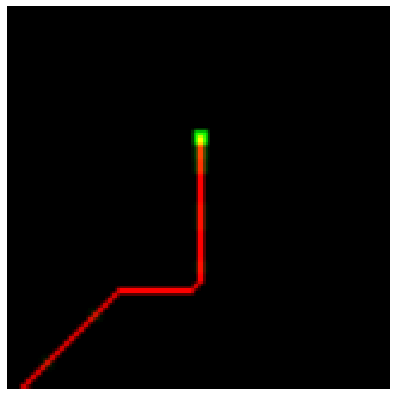

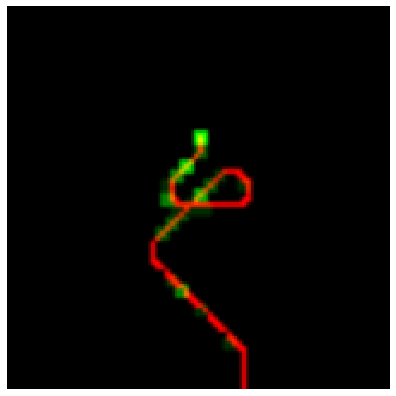

In [2]:
"""Plume trail"""

model_path = data_dir / 'plume_agent.zip'

trail_args = {
    'wind_speed': 5,
    'length_scale': 20,
    'heading': 0,
    'start_rate': 0.25,
    'max_steps': 'auto',
}

n_samps = 15

path = Path(f'plume_examples/')
if not path.exists():
    path.mkdir()

for i in tqdm(range(n_samps)):

    maps = []
    position_hists = []
    odor_hists = []

    trail_map = PlumeTrail(**trail_args)
    _, info = run_model(model_path, trail_map)
    agent = info['agent']

    maps.append(trail_map)
    position_hists.append(np.array(agent.position_history))
    odor_hists.append(agent.odor_history)

    fig, axs = plt.subplots(1, 1, figsize=(6, 12))

    for ax, m, p_hist, odor_hist in zip([axs], maps, position_hists, odor_hists):
        odor_hist = np.array(odor_hist)
        odor_hist = odor_hist[odor_hist[:,0] > 0]

        x_min = min(-30, np.min(p_hist[:,0]))
        x_max = max(30, np.max(p_hist[:,0]))

        y_min = min(-50, np.min(p_hist[:,1]))
        y_max = max(10, np.max(p_hist[:,1]))

        m.plot(ax=ax, x_lim=(x_min-20, x_max+20), y_lim=(y_min - 20, y_max + 20))
        ax.plot(p_hist[:,0], p_hist[:,1], linewidth=1.5, color='black')
        ax.scatter(odor_hist[:,1], odor_hist[:,2], color='darkturquoise', alpha=0.8, s=20)

    ratio = (y_max - y_min + 40) / (x_max - x_min + 40)
    height = 6 * ratio

    fig.set_size_inches((6, height))
    fig.tight_layout()

    plt.axis('off')
    plt.savefig(str(path / f'example_{i}.svg'))
    
    plt.clf()

    plot_observations(i, info['obs'], path)


# Plot success rate

In [15]:
"""Meander estimates"""

def plot_estimates(df, probs, name, save_path=None):
    idx = None
    if name == 'adp':
        idx = 0
    elif name == 'inc':
        idx = 1
    else:
        raise ValueError('name should be "adp" or "inc"')

    traj = np.array([t for t in df.runs[idx][0]])

    plt.gcf().set_size_inches(8, 3)
    ax = plt.gca()

    ticks = np.arange(6)
    ax.set_yticks(ticks, np.flip(np.arange(6) + 1))
    ax.set_ylabel('N')
    ax.set_xlabel('Steps')

    ratio = probs[:,1:] / (probs[:,:-1] + 1e-8)
    ratio = np.concatenate((probs[:,[0]], ratio), axis=1)
    ratio = np.clip(ratio, 0.01, 0.99)
    qr = np.log(ratio / (1 - ratio))

    qr = probs
    qr = np.flip(qr.T, axis=0)
    ax.imshow(qr, aspect='auto')

    ax.plot(4.6 - traj, color='red', linewidth=3)

    plt.gcf().tight_layout()

    if save_path is not None:
        plt.savefig(save_path)


estm_dir = Path(data_dir / 'trail_sample/estimates')
estimates = {}

for fp in estm_dir.iterdir():
    if fp.suffix != '.npy':
        continue

    name, idx, _ = fp.name.split('.')
    _, teacher_name, _ = name.split('_')
    if idx not in estimates:
        estimates[idx] = {}

    estimates[idx][teacher_name] = np.load(fp)

for fp in estm_dir.iterdir():
    if fp.suffix != '.pkl':
        continue
    
    _, _, idx = fp.stem.split('_')
    estimates[idx]['df'] = pd.read_pickle(fp)

save_dir = Path('meander_est_plots')
if not save_dir.exists():
    save_dir.mkdir()

for idx, res in estimates.items():
    print(res.keys())
    for name in ('inc', 'adp'):
        plot_estimates(res['df'], res[name], name, save_path=save_dir / f'meander_{idx}_{name}.png')
        plt.clf()

dict_keys(['adp', 'inc', 'df'])
dict_keys(['inc', 'adp', 'df'])
dict_keys(['adp', 'inc', 'df'])
dict_keys(['inc', 'adp', 'df'])
dict_keys(['inc', 'adp', 'df'])


<Figure size 576x216 with 0 Axes>

In [14]:
"""Plume estimates"""

def plot_estimates(df, probs, name, save_path=None):
    idx = None
    if name == 'adp':
        idx = 0
    elif name == 'inc':
        idx = 1
    else:
        raise ValueError('name should be "adp" or "inc"')

    traj = np.array([t for t, _ in df.runs[idx][0]])

    plt.gcf().set_size_inches(8, 3)
    ax = plt.gca()

    ticks = np.arange(8)
    ax.set_yticks(ticks, np.flip(np.arange(8) + 1))
    ax.set_ylabel('N')
    ax.set_xlabel('Steps')

    ratio = probs[:,1:] / (probs[:,:-1] + 1e-8)
    ratio = np.concatenate((probs[:,[0]], ratio), axis=1)
    ratio = np.clip(ratio, 0.01, 0.99)
    qr = np.log(ratio / (1 - ratio))

    qr = probs
    qr = np.flip(qr.T, axis=0)
    ax.imshow(qr, aspect='auto')

    ax.plot(6.5 - traj, color='red', linewidth=3)

    plt.gcf().tight_layout()

    if save_path is not None:
        plt.savefig(save_path)


estm_dir = Path(data_dir / 'plume_sample/estimates')
estimates = {}

for fp in estm_dir.iterdir():
    if fp.suffix != '.npy':
        continue

    name, idx, _ = fp.name.split('.')
    _, teacher_name, _ = name.split('_')
    if idx not in estimates:
        estimates[idx] = {}

    estimates[idx][teacher_name] = np.load(fp)

for fp in estm_dir.iterdir():
    if fp.suffix != '.pkl':
        continue
    
    _, _, idx = fp.stem.split('_')
    estimates[idx]['df'] = pd.read_pickle(fp)

save_dir = Path('plume_est_plots')
if not save_dir.exists():
    save_dir.mkdir()

for idx, res in estimates.items():
    print(res.keys())
    for name in ('inc', 'adp'):
        plot_estimates(res['df'], res[name], name, save_path=save_dir / f'plume_{idx}_{name}.png')
        plt.clf()

dict_keys(['inc', 'adp', 'df'])
dict_keys(['adp', 'inc', 'df'])
dict_keys(['adp', 'inc', 'df'])
dict_keys(['adp', 'inc', 'df'])
dict_keys(['inc', 'adp', 'df'])


<Figure size 576x216 with 0 Axes>